In [1]:
# Cell 1: Imports & load metadata

import os
import json
import math
from typing import List, Dict, Any, Optional

import numpy as np
import pandas as pd

# Paths (change if needed)
INPUT_FILE = "metadata/train_metadata.json"
AUDIO_DIR = "train/signals"
OUTPUT_FILE = "metadata/train_metadata_with_duration.json"

# Load JSON
with open(INPUT_FILE, "r", encoding="utf-8") as f:
    data: List[Dict[str, Any]] = json.load(f)

# Quick sanity check
len(data), data[0] if data else None


(8802,
 {'signal': 'c221f2084c780e8f212f4697',
  'fma': '147301',
  'original_prompt': 'cos you better hold on',
  'prompt': 'cos you better hold on',
  'original_response': '#',
  'response': '',
  'n_words': 5,
  'words_correct': 0,
  'correctness': 0.0,
  'hearing_loss': 'Moderate'})

In [2]:
# Cell 2: Add duration_ms for each audio

# Robust duration helpers
def get_duration_ms_soundfile(path: str) -> Optional[float]:
    try:
        import soundfile as sf
        info = sf.info(path)
        if info.samplerate and info.frames:
            return (info.frames / float(info.samplerate)) * 1000.0
    except Exception:
        return None
    return None

def get_duration_ms_librosa(path: str) -> Optional[float]:
    try:
        import librosa
        dur = librosa.get_duration(path=path)  # seconds
        return float(dur) * 1000.0
    except Exception:
        return None

def get_duration_ms_audioread(path: str) -> Optional[float]:
    # Very lightweight duration estimate using audioread decode
    try:
        import audioread
        with audioread.audio_open(path) as f:
            return float(f.duration) * 1000.0
    except Exception:
        return None

def get_duration_ms(path: str) -> Optional[float]:
    # Try soundfile -> librosa -> audioread
    for fn in (get_duration_ms_soundfile, get_duration_ms_librosa, get_duration_ms_audioread):
        ms = fn(path)
        if ms is not None and math.isfinite(ms) and ms > 0:
            return ms
    return None

# Compute and attach duration_ms
missing_files = []
failed_durations = []

for row in data:
    signal_id = row.get("signal", "")
    audio_path = os.path.join(AUDIO_DIR, f"{signal_id}.flac")
    if not os.path.exists(audio_path):
        row["duration_ms"] = None
        missing_files.append(audio_path)
        continue

    dur_ms = get_duration_ms(audio_path)
    row["duration_ms"] = None if dur_ms is None else float(dur_ms)
    if dur_ms is None:
        failed_durations.append(audio_path)

print(f"Processed: {len(data)} items")
print(f"Missing files: {len(missing_files)}")
print(f"Failed to compute duration: {len(failed_durations)}")

# Peek at an example with duration
next((r for r in data if r.get("duration_ms") is not None), None)


Processed: 8802 items
Missing files: 0
Failed to compute duration: 0


{'signal': 'c221f2084c780e8f212f4697',
 'fma': '147301',
 'original_prompt': 'cos you better hold on',
 'prompt': 'cos you better hold on',
 'original_response': '#',
 'response': '',
 'n_words': 5,
 'words_correct': 0,
 'correctness': 0.0,
 'hearing_loss': 'Moderate',
 'duration_ms': 3622.312925170068}

In [3]:
# Cell 3: Save the updated metadata (with duration_ms) to a new file

# Ensure output folder exists
os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)

with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print(f"Saved updated metadata to: {OUTPUT_FILE}")


Saved updated metadata to: metadata/train_metadata_with_duration.json


In [7]:
# Cell 4: Compute average word length per item

def count_words(text: Optional[str]) -> int:
    if not text:
        return 0
    # Split on whitespace; strip punctuation lightly (optional)
    # Keep it simple and robust:
    return len([w for w in str(text).strip().split() if len(w) > 0])

for row in data:
    n_words_prompt = count_words(row.get("prompt", ""))
    dur_ms = row.get("duration_ms", None)
    if dur_ms is None or not math.isfinite(dur_ms) or dur_ms <= 0 or n_words_prompt == 0:
        row["avg_word_duration_ms"] = None
    else:
        row["avg_word_duration_ms"] = float(dur_ms) / float(n_words_prompt)

# Turn into DataFrame for downstream analysis
df = pd.DataFrame(data)

# Basic summary by hearing_loss (optional but handy)
summary = (
    df[["hearing_loss", "avg_word_duration_ms", "correctness"]]
    .dropna(subset=["avg_word_duration_ms", "correctness"])
    .groupby("hearing_loss")
    .agg(
        count=("avg_word_duration_ms", "size"),
        avg_word_len_ms=("avg_word_duration_ms", "mean"),
        avg_correctness=("correctness", "mean"),
    )
    .sort_index()
)

display(df.head(3))
display(summary)


,signal,fma,original_prompt,prompt,original_response,response,n_words,words_correct,correctness,hearing_loss,duration_ms,avg_word_length_ms,avg_word_duration_ms
0,c221f2084c780e8f212f4697,147301,cos you better hold on,cos you better hold on,#,,5,0,0.000000,Moderate,3622.312925,724.462585,724.462585
1,63de05fbfcab2d7748b83cb3,000649,And then lower it down again,and then lower it down again,I don't know where it's all the same,i do not know where it is all the same,6,1,0.166667,Mild,2493.242630,415.540438,415.540438
2,cf74c013a02d82d04254a910,022968,"the blind sleep, and the deaf and dumb sleep",the blind sleep and the deaf and dumb sleep,The blind sleep and the deaf under sleep,the blind sleep and the deaf under sleep,9,7,0.777778,No Loss,4578.049887,508.672210,508.672210


,count,avg_word_len_ms,avg_correctness
hearing_loss,,,
Mild,2935,628.785918,0.395820
Moderate,2934,628.841940,0.316683
No Loss,2933,628.203906,0.580237


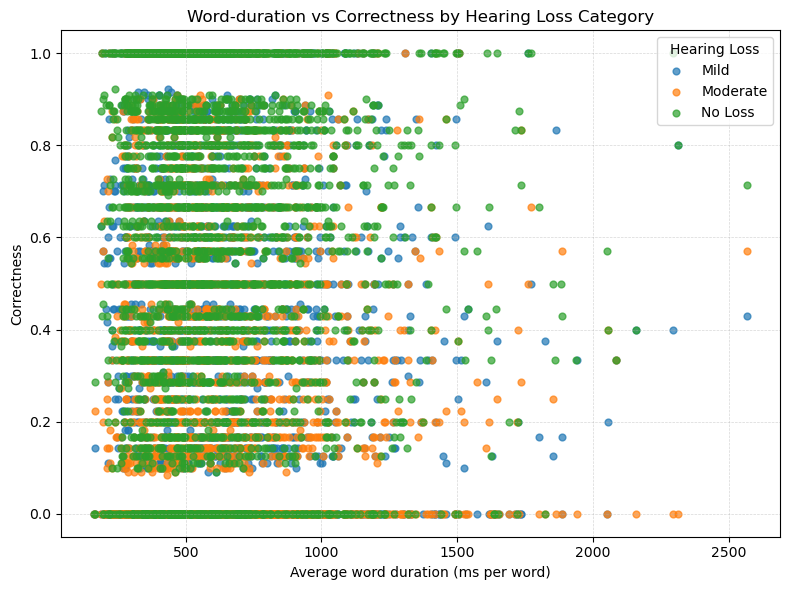

In [8]:
# Cell 5: Scatter plot of avg_word_length_ms vs correctness, colored by hearing_loss

import matplotlib.pyplot as plt

# Keep only the three categories and non-null data
allowed = {"No Loss", "Mild", "Moderate"}
plot_df = df[
    df["hearing_loss"].isin(allowed)
].dropna(subset=["avg_word_duration_ms", "correctness"])

# Create a simple scatter per category (matplotlib assigns default colors)
plt.figure(figsize=(8, 6))
for cat in sorted(allowed):
    sub = plot_df[plot_df["hearing_loss"] == cat]
    if not sub.empty:
        plt.scatter(
            sub["avg_word_duration_ms"].values,
            sub["correctness"].values,
            label=cat,
            alpha=0.7,
            s=24,
        )

plt.xlabel("Average word duration (ms per word)")
plt.ylabel("Correctness")
plt.title("Word-duration vs Correctness by Hearing Loss Category")
plt.legend(title="Hearing Loss")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


Mild       | slope=-0.000085, intercept=0.449
Moderate   | slope=-0.000080, intercept=0.367
No Loss    | slope=-0.000005, intercept=0.584


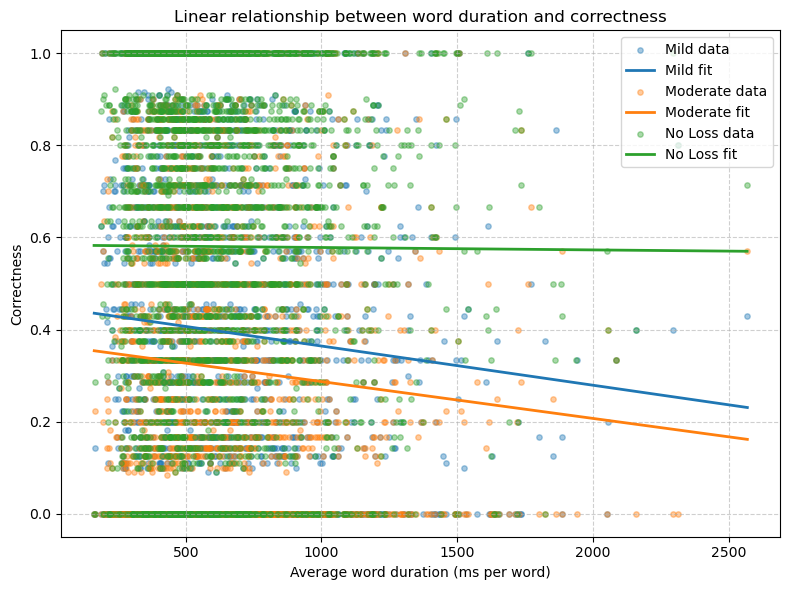

In [10]:
# Cell 7: Check for linear relationship between avg_word_length_ms and correctness

import matplotlib.pyplot as plt
import numpy as np

# Clean data
linear_df = df.dropna(subset=["avg_word_duration_ms", "correctness", "hearing_loss"])
linear_df = linear_df[linear_df["avg_word_duration_ms"] > 0]

plt.figure(figsize=(8, 6))

for cat in sorted(linear_df["hearing_loss"].unique()):
    sub = linear_df[linear_df["hearing_loss"] == cat]
    if len(sub) < 5:
        continue

    x = sub["avg_word_duration_ms"].values
    y = sub["correctness"].values

    # Scatter
    plt.scatter(x, y, alpha=0.4, s=15, label=f"{cat} data")

    # Fit linear regression line (degree=1)
    slope, intercept = np.polyfit(x, y, 1)
    y_pred = slope * np.array(x) + intercept
    x_sorted = np.sort(x)
    plt.plot(x_sorted, slope * x_sorted + intercept, linewidth=2, label=f"{cat} fit")

    print(f"{cat:<10} | slope={slope:.6f}, intercept={intercept:.3f}")

plt.xlabel("Average word duration (ms per word)")
plt.ylabel("Correctness")
plt.title("Linear relationship between word duration and correctness")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
